In [1]:
%load_ext line_profiler

In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import time
import pickle

from collections import Counter, defaultdict, OrderedDict, namedtuple
import random
import copy
import bisect
import heapq

import multiprocessing as mp
from multiprocessing import Pool

In [3]:
import warnings
warnings.filterwarnings('error')

In [10]:
records = pd.read_csv('data/ydata-fp-td-clicks-v2_0.20111002',
           sep=' ',
           names=['timestamp','id','clicked'],
           usecols=[0,1,2],
           )
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [35]:
records = pd.concat([pd.read_csv('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i), 
                                 sep=' ',
                                 names=['timestamp','id','clicked'],
                                 usecols=[0,1,2],) for i in range(2,17)])

In [6]:
lifespans = {}
for i in range(2,17):
    with open('data/ydata-fp-td-clicks-v2_0.'+ str(20111000+i)) as f:
        for line in f.readlines():
            timestamp = int(line[:10])
            components = line.strip().split(' |')
            for article in components[2:]:
                if article in lifespans:
                    lifespans[article][1] = timestamp
                else:
                    lifespans[article] = [timestamp, timestamp]

In [150]:
records.head()

,timestamp,id,clicked
0,1317513291,id-560620,0
1,1317513291,id-565648,0
2,1317513291,id-563115,0
3,1317513292,id-552077,0
4,1317513292,id-564335,0


In [38]:
with open('records','wb') as f:
    pickle.dump(records, f)

In [15]:
with open('lifespans', 'wb') as f:
    pickle.dump(lifespans, f)

In [144]:
class Arm:
    def __init__(self,lifespan):
        self.birth, self.death = lifespan
        #self.s = None
        #self.l = None
        self.T = 0
        self.rewards = 0
        self.X = -1
    def __repr__(self):
        return '{:.4f} {}/{} lifespan: {}'.format(self.X, self.rewards, self.T, (self.birth, self.death))
pool = {}
for k in lifespans:
    pool[k] = Arm(lifespans[k])
unborn = list(sorted(pool.keys(), key=lambda k:pool[k].birth, reverse=True))

In [58]:
pool

{'id-490956': -1.0000 0/0 lifespan: (1317634200, 1317660299),
 'id-552077': -1.0000 0/0 lifespan: (1317513291, 1317515399),
 'id-555224': -1.0000 0/0 lifespan: (1317513291, 1317588299),
 'id-555317': -1.0000 0/0 lifespan: (1318092300, 1318241999),
 'id-555528': -1.0000 0/0 lifespan: (1317513291, 1317587099),
 'id-559744': -1.0000 0/0 lifespan: (1317513291, 1317515699),
 'id-559833': -1.0000 0/0 lifespan: (1317577200, 1317664799),
 'id-559855': -1.0000 0/0 lifespan: (1317513291, 1317587099),
 'id-560290': -1.0000 0/0 lifespan: (1317513291, 1317587099),
 'id-560518': -1.0000 0/0 lifespan: (1317513291, 1317578399),
 'id-560591': -1.0000 0/0 lifespan: (1317650400, 1317737399),
 'id-560620': -1.0000 0/0 lifespan: (1317513291, 1317521099),
 'id-560805': -1.0000 0/0 lifespan: (1317565500, 1317651599),
 'id-560854': -1.0000 0/0 lifespan: (1317675600, 1317761099),
 'id-562265': -1.0000 0/0 lifespan: (1317569100, 1317645899),
 'id-562374': -1.0000 0/0 lifespan: (1317578100, 1317664799),
 'id-562

In [20]:
class AG_L:
    def __init__(self, records, pool, unborn):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = []
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        self.n_exploit = 0
        self.best = 'id-563643'
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        self.best = max((self.best, record.id), key= lambda arm:self.pool[arm].X)
        
    def filter_live(self):
        '''
        edit list of currently available arms
        '''
        def bisect_by_death(value):
            l = 0
            h = len(self.alive)
            while l < h:
                m = (l + h) // 2
                arm = self.alive[m]
                if self.pool[arm].death < value:
                    l = m + 1
                else:
                    h = m
            return l
        # drop dead arms
        index = bisect_by_death(self.time)
        self.alive = self.alive[ index : ]
        # pop new born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            index = bisect_by_death(self.pool[arm].death)
            self.alive.insert(index, arm)
        
    def initialize(self, m):
        for i in range(m):
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live()
            if not pool[record.id].T: # not played
                self.update(record)
    
    def play(self, n, threshold=.3):
        for t in range(n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live()
                if random.random() < self.pool[self.best].X: #exploit
                    pick = self.best
                    exploited = 1
                else: #explore
                    pick = random.choice(self.alive[int((1-threshold)*len(self.alive)) : ])
                    exploited = 0
                if pick == record.id:
                    if exploited:
                        self.n_exploit += 1
                    self.update(record)
                    break

In [39]:
agl = AG_L(records, pool, unborn)
agl.initialize(25)
agl.play(1000,.1)

In [163]:
%lprun -f agl.play agl.play(1000)

In [164]:
%%timeit
agl = AG_L(records, pool, unborn)
agl.initialize(25)
agl.play(975,.1)

294 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [160]:
class UCB_L:
    def __init__(self, records, pool, unborn):
        self.records = records.itertuples()
        self.rewards = 0
        self.alive = [] # heap: (death, id)
        self.pool = copy.deepcopy(pool) # ordered dict of arms
        self.unborn = copy.deepcopy(unborn)
        #self.avg_life = 0
        self.X = 0
        
    def update(self, record):
        self.rewards += record.clicked
        self.pool[record.id].rewards += record.clicked
        self.pool[record.id].T += 1
        self.pool[record.id].X = self.pool[record.id].rewards / self.pool[record.id].T
        n_seen = len(self.pool) - len(self.unborn)
        self.X = (self.X * (n_seen-1) + record.clicked) / n_seen
    
    def filter_live(self, t):  
        # pop born arms to alive
        while self.unborn and self.pool[self.unborn[-1]].birth<=self.time:
            arm = self.unborn.pop()
            #self.pool[arm].s = t
            heapq.heappush(self.alive, (self.pool[arm].death, arm))
        # pop dead arms from alive
        while self.alive:
            death, arm = self.alive[0]
            if death < self.time:
                heapq.heappop(self.alive)
                '''dying = self.pool[arm]
                dying.l = t
                n_dead = len(self.pool) - len(self.unborn) - len(self.alive)
                self.avg_life = (self.avg_life* (n_dead-1) + (dying.l-dying.s+1)) / n_dead'''
            else:
                break
        return
                
    def initialize(self, m):
        self.m = m
        for self.t in range(m):
            record = next(self.records) # raise StopIteration
            self.time = record.timestamp
            self.filter_live(self.t)
            if not pool[record.id].T: # not played
                self.update(record)
    
    def play(self, n, c=.008):
        def score(heap_tuple):
            r = self.t / (self.time - 1317513291)
            arm = self.pool[heap_tuple[1]]
            if arm.T:
                T = arm.T
                X = arm.X
            else: # if it's never played, use estimation
                T = 1
                X = self.X
            if c:
                return X + c*np.log(r*(arm.death - self.time) + 1) * np.sqrt( 2*np.log(r*(self.time - arm.birth) + 1)/T)
            else:
                return X + np.sqrt( 2*np.log(r*(self.time - arm.birth) + 1)/T)
            '''if not self.avg_life:
                return X
            try:
                return X + c*np.log(self.avg_life+arm.s-t+1) * np.sqrt(2*np.log(t - arm.s+1)/T)
            except RuntimeWarning:
                #print(self.avg_life, arm.s, t)
                return X'''
        self.n = n
        for self.t in range(self.m, n):
            while True: # keep trying
                record = next(self.records) # raise StopIteration
                self.time = record.timestamp
                self.filter_live(self.t)
                pick = max(self.alive, key=score)[1]
                if pick == record.id:
                    self.update(record)
                    break

In [137]:
ucbl = UCB_L(records, pool, unborn)
ucbl.initialize(25)
ucbl.play(1000,.008)

In [140]:
ucbl.rewards

43

In [154]:
def play(records):
    ucbl = UCB_L(records, pool, unborn)
    ucbl.initialize(25)
    ucbl.play(100000, .008)
    return ucbl.rewards
plt_ucbl = []
for j in range(25):
    with Pool(4) as p:
        plt_ucbl += p.map(play, [records[(i+4*j)*10000:] for i in range(4)])

(array([ 1.,  2., 10., 13., 18.,  7., 18., 14., 13.,  4.]),
 array([4319. , 4385.3, 4451.6, 4517.9, 4584.2, 4650.5, 4716.8, 4783.1,
        4849.4, 4915.7, 4982. ]),
 <a list of 10 Patch objects>)

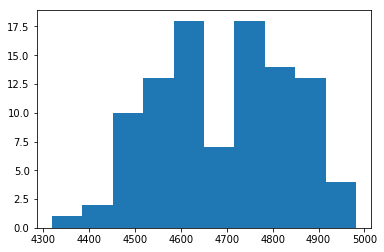

In [179]:
def play(records):
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, .3)
    return agl.rewards
plt_agl = []
for j in range(25):
    print(j, end='\r', flush=True)
    with Pool(4) as p:
        plt_agl += p.map(play, [records[(i+4*j)*10000:] for _ in range(4)])
plt.hist(plt_agl)

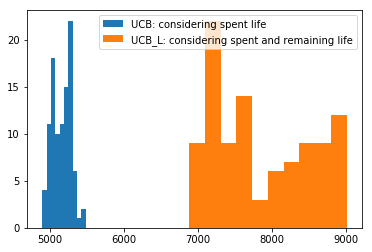

In [176]:
plt.hist(plt_ucb, bins=10, label='UCB: considering spent life')
plt.hist(plt_ucbl, bins=10, label='UCB_L: considering spent and remaining life')
plt.legend()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


(array([ 4., 11., 18., 10., 11., 15., 22.,  6.,  1.,  2.]),
 array([4892., 4951., 5010., 5069., 5128., 5187., 5246., 5305., 5364.,
        5423., 5482.]),
 <a list of 10 Patch objects>)

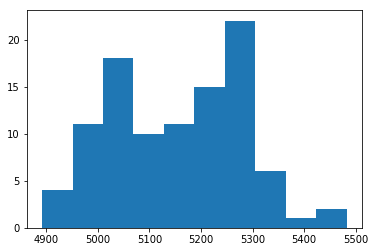

In [170]:
def play(records):
    ucb = UCB_L(records, pool, unborn)
    ucb.initialize(25)
    ucb.play(100000, c=None)
    return ucb.rewards
plt_ucb = []
for j in range(25):
    print(j, flush=True)
    with Pool(4) as p:
        plt_ucb += p.map(play, [records[(i+4*j)*10000:] for i in range(4)])
plt.hist(plt_ucb)

(array([ 6.,  6., 21., 24., 20., 14.,  3.,  4.,  1.,  1.]),
 array([4365. , 4400.9, 4436.8, 4472.7, 4508.6, 4544.5, 4580.4, 4616.3,
        4652.2, 4688.1, 4724. ]),
 <a list of 10 Patch objects>)

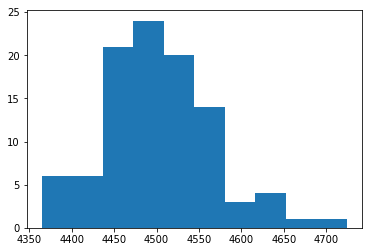

In [167]:
def play(args):
    records, pool = args
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, .3)
    return agl.rewards
plt_agl = []
with Pool(4) as p:
    plt_agl += p.map(play, [(records, pool) for _ in range(100)])
plt.hist(plt_agl)

(array([ 6.,  9., 10., 13., 19., 12., 12., 11.,  3.,  5.]),
 array([4404. , 4429.3, 4454.6, 4479.9, 4505.2, 4530.5, 4555.8, 4581.1,
        4606.4, 4631.7, 4657. ]),
 <a list of 10 Patch objects>)

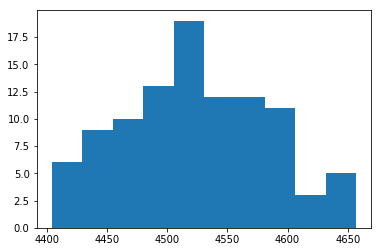

In [64]:
res = []
with Pool(4) as p:
    res = p.map(play, [(records, pool) for _ in range(100)])
plt.hist(res)

(array([ 4., 10., 15., 20., 25.,  6., 14.,  5.,  0.,  1.]),
 array([3664. , 3698.5, 3733. , 3767.5, 3802. , 3836.5, 3871. , 3905.5,
        3940. , 3974.5, 4009. ]),
 <a list of 10 Patch objects>)

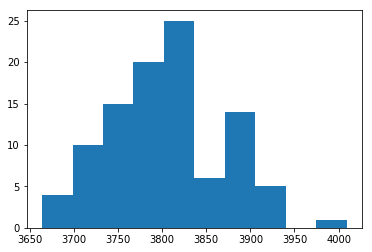

In [75]:
def play(args):
    records, pool = args
    agl = AG_L(records, pool, unborn)
    agl.initialize(25)
    agl.play(100000, 1)
    return agl.rewards
ag = []
with Pool(4) as p:
    ag = p.map(play, [(records, pool) for _ in range(100)])
plt.hist(ag)

In [78]:
sum(agl)

452338

In [79]:
sum(ag)

380490

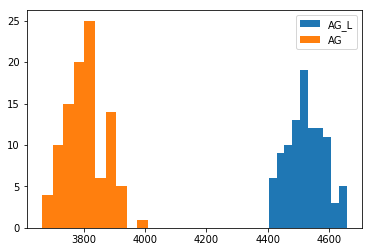

In [80]:
plt.hist(agl, label='AG_L')
plt.hist(ag, label='AG')
plt.legend()